# Fid light acquisition offsets

Review fid light acquisition placement and determine model of placement based on the chandra_aca.drift model.

This notebook includes a quick fit of the chandra_aca.drift model (last fit 2022-11) to the fid acquisition offsets. 


In [1]:
import os
os.environ['SKA'] = '/Users/jean/ska'
import sys


In [2]:
from pathlib import Path
import astropy.units as u
from astropy.table import Table
from cheta import fetch_sci as fetch

import ska_dbi
from cxotime import CxoTime
from ska_matplotlib import plot_cxctime
import matplotlib.pyplot as plt
import numpy as np


In [3]:

import fid_drift_mon.plot_command_vs_telem
from fid_drift_mon.plot_command_vs_telem import (get_fids_telem, get_fids_commands,
                                                 get_dwells_with_fids, join_commands_telem)

In [4]:

def FID_STATS_PATH(data_dir):
    return Path(data_dir) / "fid_stats.db3"

In [5]:
# Use all available data to start
start = CxoTime('2001:001')
stop = CxoTime.now()

In [6]:
# Turn off the logger
fid_drift_mon.plot_command_vs_telem.logger.setLevel('ERROR')

In [7]:
# Make a data file of the useful pieces.
# This was previously the data used to make the starcheck_telem.png with commanded fid placement
# and observed values in Y ad Z
fid_data_file = 'fid_commands_telem.dat'

In [8]:

if not Path(fid_data_file).exists():
    # If the data file does not exist, use the methods in plot_command_vs_telem to get data
    dwells = get_dwells_with_fids(start.date, stop.date);
    fids_commands = get_fids_commands(dwells);
    with ska_dbi.DBI(dbi='sqlite', server=FID_STATS_PATH('.')) as db:
        fids_telem = get_fids_telem(dwells, fids_commands, db)
    commands_telem = join_commands_telem(fids_commands, fids_telem)
    commands_telem.write(fid_data_file, format='ascii')
else:
    commands_telem = Table.read(fid_data_file, format='ascii')

## Review data over the limit

During the interval after the 2022:294 save mode and before the fid search box sizes were increased to 40 arcsecs, the Y angles sometimes exceeded the 20 arcsec halfwidth, yet fid lights were still acquired. 

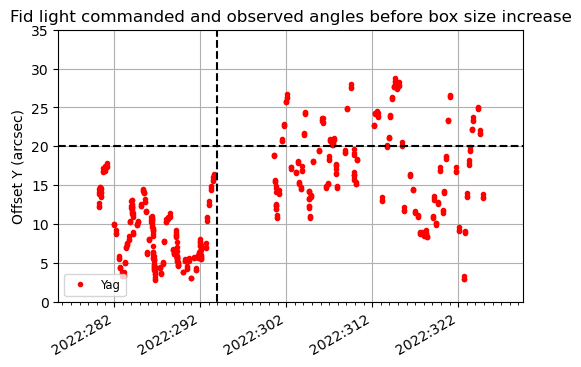

In [9]:

plt.figure(1, figsize=(6, 4))
ok = ((commands_telem['tstart'] > CxoTime('2022:280').secs)
      & (commands_telem['tstart'] < CxoTime('2022:325').secs))
tstart = commands_telem["tstart"][ok]
dyag = commands_telem["aoacyan"][ok] - commands_telem["yang"][ok]
plot_cxctime(tstart, dyag, "r.", label=f"Yag")
plt.ylim(-0, 35)
plt.grid()
plt.legend(fontsize="small", numpoints=1, loc="lower left")
plt.ylabel("Offset Y (arcsec)")
plt.title("Fid light commanded and observed angles before box size increase")
x0, x1 = plt.xlim()
dx = (x1 - x0) * 0.05
x0, x1 = x0 - dx, x1 + dx
plt.xlim(x0, x1)
plt.hlines([-20, 20], x0, x1, colors="k", linestyles="--")
# plot a vertical line
plt.vlines(CxoTime('2022:294').plot_date, -20, 45, colors="k", linestyles="--");
plt.savefig("overlimit.png")


In [10]:
np.max(dyag)

28.834485837822058

These data suggest that exceeding the limit by up to 5 arcsecs may be safe.

## Fit fid aimpoint drift model

The chandra_aca.drift model already captures an ACA offset that describes the expected difference in the fid positions, but it is not calibrated to zero out the fid placement. The current zero-offset placement for the fid lights correstponds to the FEB07 fid calibration.  Below, we calibrate the fid light offsets from expected positions at the acquisition temperatures to the aimpoint drift model in the 2022:294 to 2023:047 epoch (last calibrated aimpoint drift model).

### Fit in Y

In [11]:
commands_telem.sort('tstart')
tstart = commands_telem["tstart"]
ok = ((commands_telem['tstart'] > CxoTime('2022:294').secs)
      & (commands_telem['tstart'] < CxoTime('2023:047').secs))
dat = fetch.Msid('AACCCDPT', tstart[ok][0], tstart[ok][-1], stat='5min')
from chandra_aca.drift import AcaDriftModel, DRIFT_PARS, SIM_MM_TO_ARCSEC
drift_y = AcaDriftModel(**DRIFT_PARS['dy']) 
t_ccd = np.interp(tstart[ok], dat.times, dat.vals)
dy = drift_y.calc(tstart[ok], t_ccd) # The docs suggest this is mm but I think maybe arcsec

-0.9935363891893869 20.307810657547783


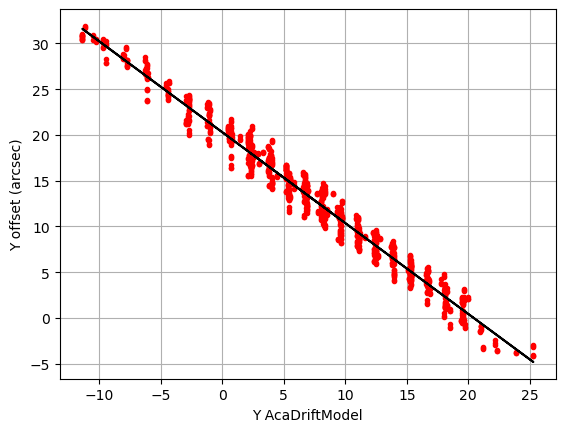

In [12]:
plt.plot(dy, commands_telem['aoacyan'][ok] - commands_telem['yang'][ok], 'r.')
m, b = np.polyfit(dy, commands_telem['aoacyan'][ok] - commands_telem['yang'][ok], 1)
print(m, b)
plt.plot(dy, (m * dy) + b, 'k-')
plt.ylabel("Y offset (arcsec)")
plt.xlabel("Y AcaDriftModel")
plt.grid()

The slope is basically -1, so let's just use that and double-check that b is still reasonable by eye.

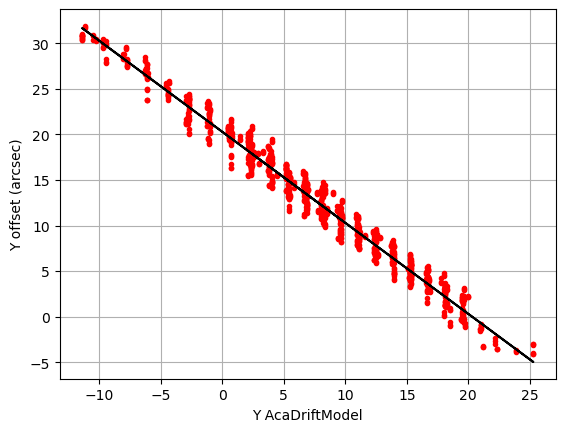

In [13]:
plt.plot(dy, commands_telem['aoacyan'][ok] - commands_telem['yang'][ok], 'r.')
# with a little manual adjustment of the coefficients
m = -1
b = 20.3
plt.plot(dy, m * dy + b, 'k-')
plt.ylabel("Y offset (arcsec)")
plt.xlabel("Y AcaDriftModel")
plt.grid()

### Fit in Z

In [14]:
from chandra_aca.drift import AcaDriftModel, DRIFT_PARS, SIM_MM_TO_ARCSEC
drift_z = AcaDriftModel(**DRIFT_PARS['dz']) 
t_ccd = np.interp(tstart[ok], dat.times, dat.vals)
dz = drift_z.calc(tstart[ok], t_ccd) # The docs suggest this is mm but I think maybe arcsec

-0.9632137905941299 19.79680107660068


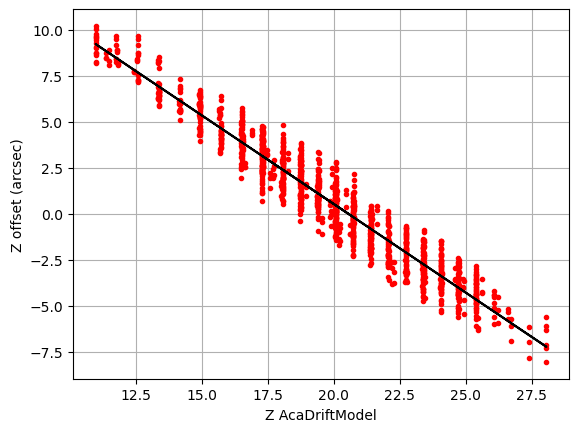

In [15]:
plt.plot(dz, commands_telem['aoaczan'][ok] - commands_telem['zang'][ok], 'r.')
m, b = np.polyfit(dz, commands_telem['aoaczan'][ok] - commands_telem['zang'][ok], 1)
print(m, b)
plt.plot(dz, m * dz + b, 'k-')
plt.ylabel("Z offset (arcsec)")
plt.xlabel("Z AcaDriftModel")
plt.grid()

As with Y, the slope is basically -1.  See if an offset of the same as Y is also reasonable by eye.

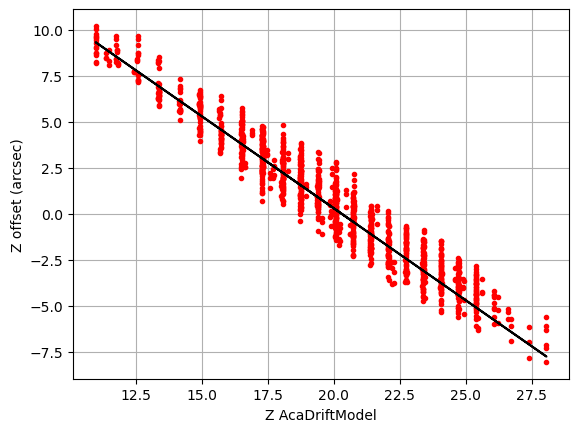

In [16]:
plt.plot(dz, commands_telem['aoaczan'][ok] - commands_telem['zang'][ok], 'r.')
# With manual adjustment of coefficient and slope -1
m = -1
b = 20.3
plt.plot(dz, m * dz + b, 'k-')
plt.ylabel("Z offset (arcsec)")
plt.xlabel("Z AcaDriftModel")
plt.grid()

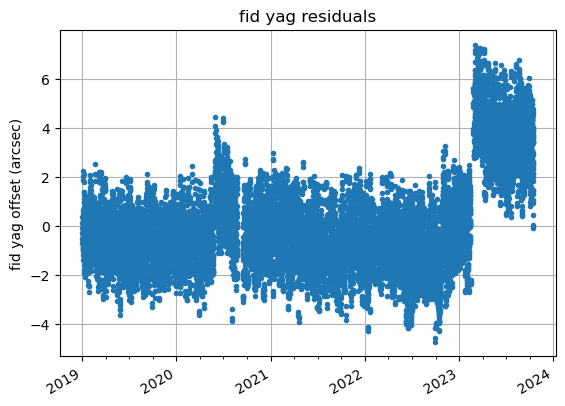

In [17]:
# Make a plot of y fid residuals to the manual coefficients
m = -1
b = 20.3
ok = commands_telem['tstart'] > CxoTime('2019:001').secs
tstart = commands_telem['tstart'][ok]
dat = fetch.Msid('AACCCDPT', tstart[0], tstart[-1], stat='5min')
t_ccd = np.interp(tstart, dat.times, dat.vals)
dy = drift_y.calc(tstart, t_ccd)
plot_cxctime(tstart,
            (commands_telem['aoacyan'][ok] - commands_telem['yang'][ok]) - (m * dy + b),
            '.')

plt.title('fid yag residuals')
plt.ylabel('fid yag offset (arcsec)')
plt.grid();
#plt.savefig("fid_yag_offset_residuals.png")

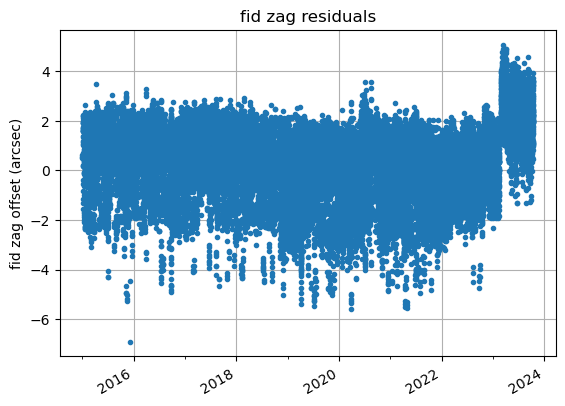

In [18]:
# Make a plot of z fid residuals
m = -1
b = 20.3
ok = commands_telem['tstart'] > CxoTime('2015:001').secs
tstart = commands_telem['tstart'][ok]
dat = fetch.Msid('AACCCDPT', tstart[0], tstart[-1], stat='5min')
t_ccd = np.interp(tstart, dat.times, dat.vals)
dz = drift_z.calc(tstart, t_ccd)
plot_cxctime(tstart,
            (commands_telem['aoaczan'][ok] - commands_telem['zang'][ok]) - (m * dz + b),
            '.')
plt.title('fid zag residuals')
plt.ylabel('fid zag offset (arcsec)')
plt.grid();
#plt.savefig("fid_zag_offset_residuals.png")

The sign and offset of these associations with the fid positions and the aimpoint drift model are reasonable.